## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import warnings
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', 20)

PALETTE = ['#635BFF', '#0A2540', '#00D4FF', '#FF7F50', '#2ECC71', '#E74C3C', '#F39C12', '#9B59B6']
plt.rcParams.update({'figure.facecolor': 'white', 'axes.spines.top': False, 'axes.spines.right': False})

os.makedirs('exports', exist_ok=True)

print('Loading transactions...')
df = pd.read_csv('data/transactions.csv', parse_dates=['timestamp'])
print(f'Loaded {len(df):,} transactions | {df.dtypes.count()} columns')
df.head(3)

Matplotlib is building the font cache; this may take a moment.


Loading transactions...
Loaded 1,000,000 transactions | 19 columns


,transaction_id,timestamp,merchant_id,merchant_category,geography,currency,payment_method,amount_usd,pre_auth_risk_score,status,failure_code,is_retryable,retry_recovered,is_recoverable,hour_of_day,day_of_week,is_weekend,month,year
0,TXN_0000000,2024-12-01 08:21:17,MID_03323,Marketplaces,UK,GBP,Bank Transfer,115.90,0.38,success,success,0,0,0,8,6,1,12,2024
1,TXN_0000001,2024-06-15 23:43:25,MID_04307,SaaS/Subscription,EU,EUR,BNPL,231.52,0.52,success,success,0,0,0,23,5,1,6,2024
2,TXN_0000002,2024-06-04 07:35:57,MID_01792,Gaming,US,USD,Debit Card,24.80,0.24,success,success,0,0,0,7,1,0,6,2024


## 2. SQL Analysis

In [2]:
# Load into in-memory SQLite for SQL-based analysis
conn = sqlite3.connect(':memory:')
df.to_sql('transactions', conn, index=False, if_exists='replace')
print('SQLite table loaded.')

def sql(query, conn=conn):
    return pd.read_sql_query(query, conn)

SQLite table loaded.


In [3]:
# ── SQL 1: High-level summary ──────────────────────────────────────────────
summary = sql("""
    SELECT
        COUNT(*)                                        AS total_transactions,
        SUM(amount_usd)                                 AS total_volume_usd,
        SUM(CASE WHEN status = 'failed' THEN 1 END)     AS total_failures,
        ROUND(100.0 * SUM(CASE WHEN status = 'failed' THEN 1 END) / COUNT(*), 2)
                                                        AS failure_rate_pct,
        SUM(CASE WHEN is_retryable = 1 THEN 1 END)      AS retryable_failures,
        SUM(CASE WHEN is_recoverable = 1 THEN 1 END)    AS recoverable_failures,
        ROUND(SUM(CASE WHEN is_recoverable = 1 THEN amount_usd ELSE 0 END), 2)
                                                        AS recoverable_revenue_usd
    FROM transactions
""")
print('=== PLATFORM SUMMARY ===')
summary.T

=== PLATFORM SUMMARY ===


,0
total_transactions,"1,000,000.00"
total_volume_usd,"165,513,628.25"
total_failures,"128,221.00"
failure_rate_pct,12.82
retryable_failures,"76,832.00"
recoverable_failures,"25,910.00"
recoverable_revenue_usd,"8,691,788.80"


In [4]:
# ── SQL 2: Failure rate & leakage by merchant category ────────────────────
by_category = sql("""
    SELECT
        merchant_category,
        COUNT(*)                                                     AS total_txns,
        SUM(CASE WHEN status='failed' THEN 1 END)                    AS failures,
        ROUND(100.0 * SUM(CASE WHEN status='failed' THEN 1 END)
              / COUNT(*), 2)                                         AS failure_rate_pct,
        SUM(CASE WHEN is_recoverable=1 THEN 1 END)                   AS recoverable_count,
        ROUND(SUM(CASE WHEN is_recoverable=1 THEN amount_usd END),0) AS leakage_usd,
        ROUND(SUM(amount_usd), 0)                                    AS total_volume_usd
    FROM transactions
    GROUP BY merchant_category
    ORDER BY leakage_usd DESC
""")
by_category['leakage_pct_of_volume'] = (by_category['leakage_usd'] / by_category['total_volume_usd'] * 100).round(2)
print('=== LEAKAGE BY MERCHANT CATEGORY ===')
by_category

=== LEAKAGE BY MERCHANT CATEGORY ===


,merchant_category,total_txns,failures,failure_rate_pct,recoverable_count,leakage_usd,total_volume_usd,leakage_pct_of_volume
0,Travel,120153,48386,40.27,9839,"5,442,056.00","64,655,065.00",8.42
1,Marketplaces,100021,23969,23.96,4747,"1,146,899.00","17,920,572.00",6.40
2,E-commerce,279924,30271,10.81,6170,"1,133,853.00","30,386,397.00",3.73
3,Healthcare,60151,5942,9.88,1218,"542,416.00","23,805,693.00",2.28
4,Retail,139768,7606,5.44,1496,"211,587.00","11,607,432.00",1.82
5,SaaS/Subscription,180104,7388,4.10,1512,"164,352.00","12,635,049.00",1.30
6,Gaming,79850,3105,3.89,649,"28,481.00","2,550,351.00",1.12
7,Food & Delivery,40029,1554,3.88,279,"22,145.00","1,953,069.00",1.13


In [5]:
# ── SQL 3: Failure rate by geography ──────────────────────────────────────
by_geo = sql("""
    SELECT
        geography,
        currency,
        COUNT(*)                                                     AS total_txns,
        ROUND(100.0 * SUM(CASE WHEN status='failed' THEN 1 END)
              / COUNT(*), 2)                                         AS failure_rate_pct,
        ROUND(SUM(CASE WHEN is_recoverable=1 THEN amount_usd END),0) AS leakage_usd
    FROM transactions
    GROUP BY geography, currency
    ORDER BY failure_rate_pct DESC
""")
print('=== FAILURE RATE BY GEOGRAPHY ===')
by_geo

=== FAILURE RATE BY GEOGRAPHY ===


,geography,currency,total_txns,failure_rate_pct,leakage_usd
0,BR,BRL,59925,18.00,"624,746.00"
1,IN,INR,79507,16.84,"849,539.00"
2,US,USD,420177,12.68,"3,712,334.00"
3,CA,CAD,49813,11.90,"386,137.00"
4,UK,GBP,100007,11.79,"785,036.00"
5,EU,EUR,200322,11.49,"1,623,490.00"
6,AU,AUD,39970,11.33,"335,635.00"
7,SG,SGD,50279,10.93,"374,873.00"


In [6]:
# ── SQL 4: Failure codes breakdown ────────────────────────────────────────
by_code = sql("""
    SELECT
        failure_code,
        is_retryable,
        COUNT(*)                                                     AS occurrences,
        ROUND(100.0 * COUNT(*) /
              SUM(COUNT(*)) OVER (), 2)                              AS pct_of_failures,
        ROUND(SUM(amount_usd), 0)                                    AS total_amount_usd,
        ROUND(AVG(amount_usd), 2)                                    AS avg_amount_usd
    FROM transactions
    WHERE status = 'failed'
    GROUP BY failure_code, is_retryable
    ORDER BY occurrences DESC
""")
print('=== FAILURE CODE DISTRIBUTION ===')
by_code

=== FAILURE CODE DISTRIBUTION ===


,failure_code,is_retryable,occurrences,pct_of_failures,total_amount_usd,avg_amount_usd
0,insufficient_funds,1,15533,12.11,"5,215,868.00",335.79
1,processing_error,1,15478,12.07,"5,112,718.00",330.32
2,network_timeout,1,15344,11.97,"5,113,814.00",333.28
3,velocity_exceeded,1,15343,11.97,"5,087,101.00",331.56
4,do_not_honor,1,15134,11.80,"5,118,334.00",338.20
5,stolen_card,0,7423,5.79,"2,486,842.00",335.02
6,lost_card,0,7410,5.78,"2,478,608.00",334.50
7,incorrect_cvc,0,7395,5.77,"2,462,702.00",333.02
8,card_expired,0,7366,5.74,"2,415,220.00",327.89
9,fraud_suspected,0,7299,5.69,"2,396,154.00",328.29


In [7]:
# ── SQL 5: Payment method failure rates ───────────────────────────────────
by_pm = sql("""
    SELECT
        payment_method,
        COUNT(*)                                                     AS total_txns,
        ROUND(100.0 * SUM(CASE WHEN status='failed' THEN 1 END)
              / COUNT(*), 2)                                         AS failure_rate_pct,
        ROUND(SUM(CASE WHEN is_recoverable=1 THEN amount_usd END),0) AS leakage_usd,
        ROUND(AVG(CASE WHEN status='success' THEN amount_usd END),2) AS avg_success_amount
    FROM transactions
    GROUP BY payment_method
    ORDER BY failure_rate_pct DESC
""")
print('=== FAILURE RATE BY PAYMENT METHOD ===')
by_pm

=== FAILURE RATE BY PAYMENT METHOD ===


,payment_method,total_txns,failure_rate_pct,leakage_usd,avg_success_amount
0,BNPL,89949,17.61,"951,388.00",136.63
1,Bank Transfer,100303,15.13,"1,003,657.00",138.65
2,Debit Card,250149,13.99,"2,308,243.00",139.21
3,Credit Card,380499,11.74,"3,183,220.00",141.72
4,Digital Wallet,179100,9.79,"1,245,280.00",144.31


In [8]:
# ── SQL 6: Monthly trend ──────────────────────────────────────────────────
monthly = sql("""
    SELECT
        year,
        month,
        COUNT(*)                                                     AS total_txns,
        ROUND(100.0 * SUM(CASE WHEN status='failed' THEN 1 END)
              / COUNT(*), 3)                                         AS failure_rate_pct,
        ROUND(SUM(CASE WHEN is_recoverable=1 THEN amount_usd END),0) AS leakage_usd
    FROM transactions
    GROUP BY year, month
    ORDER BY year, month
""")
monthly['period'] = monthly['year'].astype(str) + '-' + monthly['month'].astype(str).str.zfill(2)
print('=== MONTHLY TREND ===')
monthly

=== MONTHLY TREND ===


,year,month,total_txns,failure_rate_pct,leakage_usd,period
0,2023,7,56358,12.73,"478,289.00",2023-07
1,2023,8,55974,12.71,"473,163.00",2023-08
2,2023,9,55054,12.99,"487,942.00",2023-09
3,2023,10,56456,12.86,"503,723.00",2023-10
4,2023,11,54671,12.90,"481,119.00",2023-11
5,2023,12,56444,12.84,"505,226.00",2023-12
6,2024,1,56183,12.87,"486,732.00",2024-01
7,2024,2,53028,12.70,"472,826.00",2024-02
8,2024,3,56851,12.74,"485,483.00",2024-03
9,2024,4,54744,12.89,"473,330.00",2024-04


## 3. Visualizations

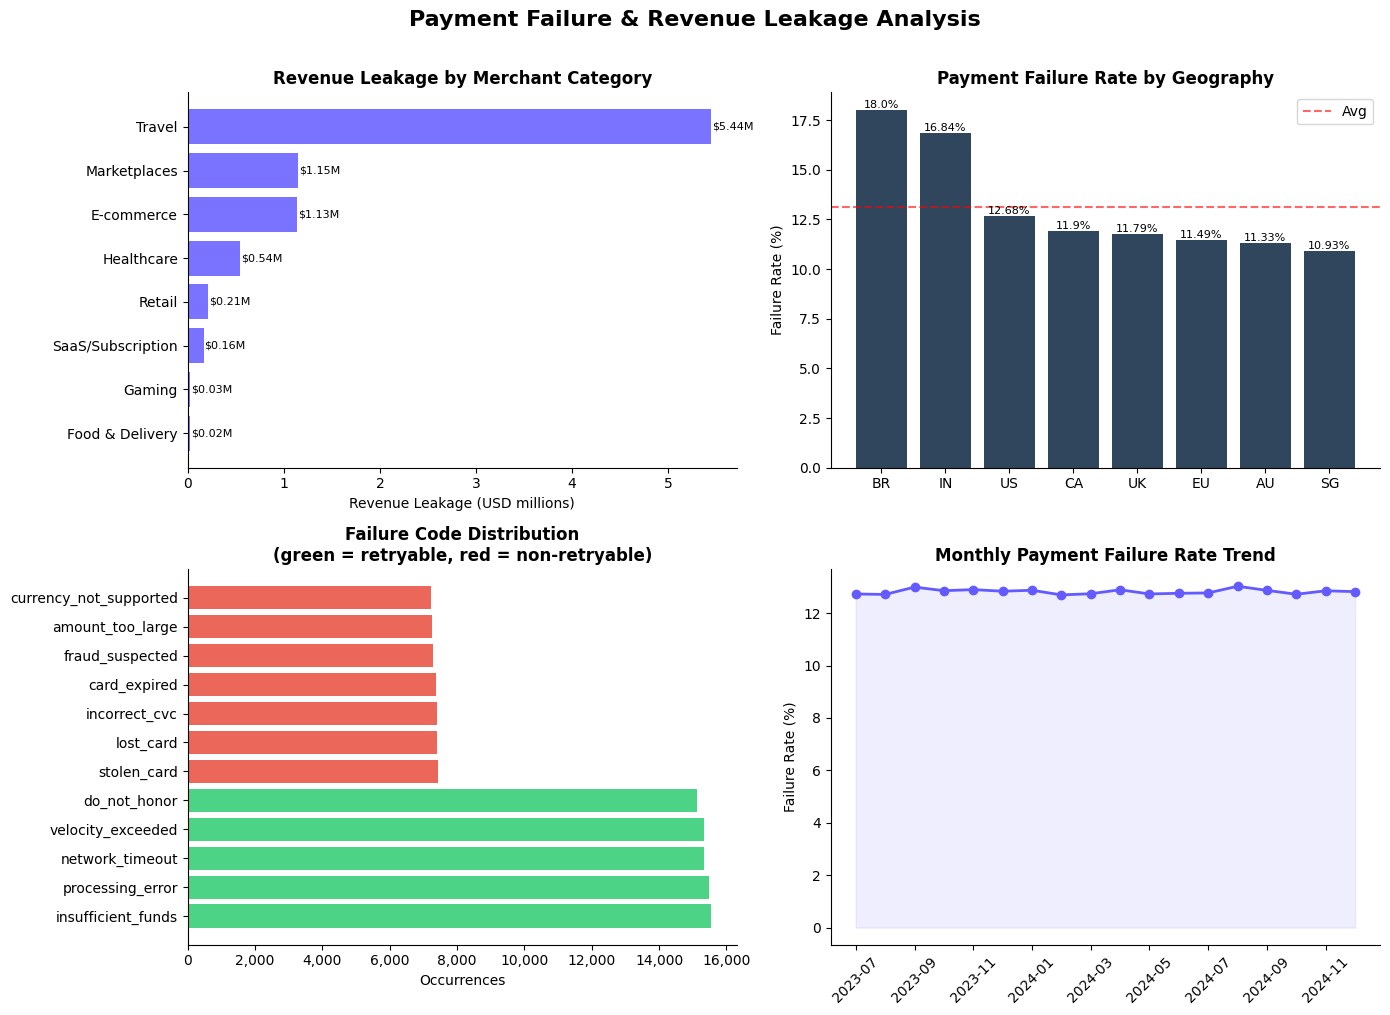

Figure saved to exports/failure_analysis.png


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Payment Failure & Revenue Leakage Analysis', fontsize=16, fontweight='bold', y=1.01)

# ── Plot 1: Leakage by merchant category ──────────────────────────────────
ax = axes[0, 0]
cat_plot = by_category.sort_values('leakage_usd', ascending=True)
bars = ax.barh(cat_plot['merchant_category'], cat_plot['leakage_usd'] / 1e6, color=PALETTE[0], alpha=0.85)
ax.set_xlabel('Revenue Leakage (USD millions)')
ax.set_title('Revenue Leakage by Merchant Category', fontweight='bold')
for bar, val in zip(bars, cat_plot['leakage_usd']):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'${val/1e6:.2f}M', va='center', fontsize=8)

# ── Plot 2: Failure rate by geography ─────────────────────────────────────
ax = axes[0, 1]
ax.bar(by_geo['geography'], by_geo['failure_rate_pct'], color=PALETTE[1], alpha=0.85)
ax.set_ylabel('Failure Rate (%)')
ax.set_title('Payment Failure Rate by Geography', fontweight='bold')
ax.axhline(by_geo['failure_rate_pct'].mean(), color='red', linestyle='--', alpha=0.6, label='Avg')
ax.legend()
for i, (geo, rate) in enumerate(zip(by_geo['geography'], by_geo['failure_rate_pct'])):
    ax.text(i, rate + 0.1, f'{rate}%', ha='center', fontsize=8)

# ── Plot 3: Failure code distribution (retryable vs not) ──────────────────
ax = axes[1, 0]
colors = [PALETTE[4] if r == 1 else PALETTE[5] for r in by_code['is_retryable']]
bars = ax.barh(by_code['failure_code'], by_code['occurrences'], color=colors, alpha=0.85)
ax.set_xlabel('Occurrences')
ax.set_title('Failure Code Distribution\n(green = retryable, red = non-retryable)', fontweight='bold')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# ── Plot 4: Monthly failure rate trend ────────────────────────────────────
ax = axes[1, 1]
ax.plot(monthly['period'], monthly['failure_rate_pct'], color=PALETTE[0], marker='o', linewidth=2)
ax.fill_between(monthly['period'], monthly['failure_rate_pct'],
                alpha=0.1, color=PALETTE[0])
ax.set_ylabel('Failure Rate (%)')
ax.set_title('Monthly Payment Failure Rate Trend', fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.set_xticks(range(0, len(monthly), 2))
ax.set_xticklabels(monthly['period'].iloc[::2], rotation=45)

plt.tight_layout()
plt.savefig('exports/failure_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved to exports/failure_analysis.png')

## 4. Revenue Leakage Quantification

In [12]:
total_volume = df['amount_usd'].sum()
failed_volume = df.loc[df['status']=='failed', 'amount_usd'].sum()
retryable_volume = df.loc[df['is_retryable']==1, 'amount_usd'].sum()
leakage_volume = df.loc[df['is_recoverable']==1, 'amount_usd'].sum()
already_recovered = df.loc[(df['is_retryable']==1) & (df['retry_recovered']==1), 'amount_usd'].sum()

sep = '=' * 55
print(sep)
print(f' Total transaction volume    : ${total_volume:>12,.0f}')
print(f' Failed transaction volume   : ${failed_volume:>12,.0f} ({failed_volume/total_volume:.1%})')
print(f' Retryable failure volume    : ${retryable_volume:>12,.0f} ({retryable_volume/total_volume:.1%})')
print(f' Already recovered (retried) : ${already_recovered:>12,.0f}')
print(f' Remaining leakage (target)  : ${leakage_volume:>12,.0f} <- recoverable')
print(f' Leakage as % of volume      : {leakage_volume/total_volume:.2%}')
print(sep)

print()
print('TOP 3 RECOVERY OPPORTUNITIES:')
top_ops = by_category[['merchant_category','leakage_usd','failure_rate_pct']].head(3)
for _, row in top_ops.iterrows():
    print(f" {row['merchant_category']:<22}: ${row['leakage_usd']:>10,.0f} leakage | {row['failure_rate_pct']}% failure rate")

 Total transaction volume    : $ 165,513,628
 Failed transaction volume   : $  42,723,551 (25.8%)
 Retryable failure volume    : $  25,647,834 (15.5%)
 Already recovered (retried) : $  16,956,045
 Remaining leakage (target)  : $   8,691,789 <- recoverable
 Leakage as % of volume      : 5.25%

TOP 3 RECOVERY OPPORTUNITIES:
 Travel                : $ 5,442,056 leakage | 40.27% failure rate
 Marketplaces          : $ 1,146,899 leakage | 23.96% failure rate
 E-commerce            : $ 1,133,853 leakage | 10.81% failure rate


## 5. Logistic Regression Model — High-Risk Transaction Flagging

In [13]:
# ── Feature engineering ───────────────────────────────────────────────────
model_df = df.copy()
model_df['target'] = (model_df['status'] == 'failed').astype(int)

# Encode categoricals
le = LabelEncoder()
for col in ['merchant_category', 'geography', 'payment_method']:
    model_df[f'{col}_enc'] = le.fit_transform(model_df[col])

# Log-transform amount (right-skewed)
model_df['log_amount'] = np.log1p(model_df['amount_usd'])

FEATURES = [
    'log_amount',
    'merchant_category_enc',
    'geography_enc',
    'payment_method_enc',
    'hour_of_day',
    'day_of_week',
    'is_weekend',
    'month',
    'pre_auth_risk_score',  # Pre-authorization risk score (computed by upstream risk model)
]

X = model_df[FEATURES].values
y = model_df['target'].values

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set : {X_train.shape[0]:,} samples  ({y_train.mean():.1%} positive)')
print(f'Test set     : {X_test.shape[0]:,} samples  ({y_test.mean():.1%} positive)')

Training set : 800,000 samples  (12.8% positive)
Test set     : 200,000 samples  (12.8% positive)


In [14]:
# ── Train logistic regression with scaling ────────────────────────────────
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=500, random_state=42, C=1.0))
])

pipe.fit(X_train, y_train)
y_pred_proba = pipe.predict_proba(X_test)[:, 1]
y_pred       = pipe.predict(X_test)

auc = roc_auc_score(y_test, y_pred_proba)
ap  = average_precision_score(y_test, y_pred_proba)

print(f'ROC-AUC  : {auc:.4f}')
print(f'Avg Prec : {ap:.4f}')
print()
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Success','Failure']))

ROC-AUC  : 0.8240
Avg Prec : 0.3810

Classification Report:
              precision    recall  f1-score   support

     Success       0.97      0.76      0.85    174356
     Failure       0.34      0.83      0.48     25644

    accuracy                           0.77    200000
   macro avg       0.65      0.79      0.66    200000
weighted avg       0.89      0.77      0.80    200000



In [15]:
# ── Cross-validation for robustness ──────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f'5-Fold CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
print(f'Fold scores  : {[f"{s:.4f}" for s in cv_scores]}')

5-Fold CV AUC: 0.8259 ± 0.0022
Fold scores  : ['0.8280', '0.8240', '0.8247', '0.8291', '0.8237']


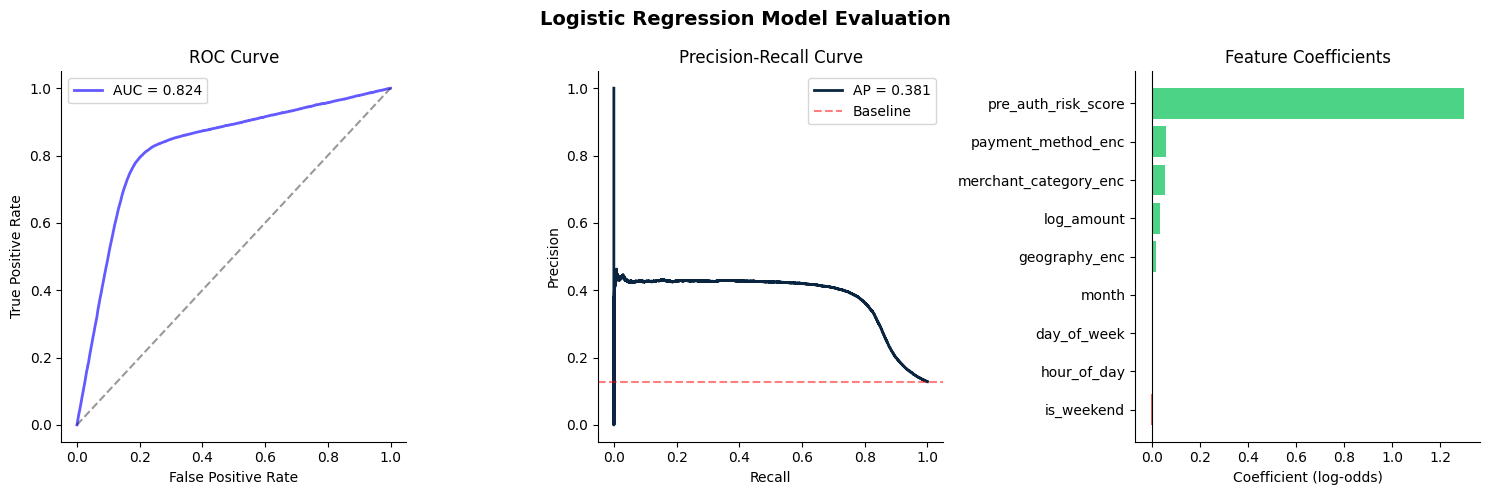

Model evaluation saved to exports/model_evaluation.png


In [16]:
# ── Model evaluation plots ────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Logistic Regression Model Evaluation', fontsize=14, fontweight='bold')

# ROC Curve
ax = axes[0]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax.plot(fpr, tpr, color=PALETTE[0], lw=2, label=f'AUC = {auc:.3f}')
ax.plot([0,1],[0,1], 'k--', alpha=0.4)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()

# Precision-Recall Curve
ax = axes[1]
prec, rec, _ = precision_recall_curve(y_test, y_pred_proba)
ax.plot(rec, prec, color=PALETTE[1], lw=2, label=f'AP = {ap:.3f}')
ax.axhline(y_test.mean(), color='red', linestyle='--', alpha=0.5, label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend()

# Feature importance (coefficients)
ax = axes[2]
coefs = pipe.named_steps['lr'].coef_[0]
feat_imp = pd.Series(coefs, index=FEATURES).sort_values()
colors_fi = [PALETTE[4] if v > 0 else PALETTE[5] for v in feat_imp]
ax.barh(feat_imp.index, feat_imp.values, color=colors_fi, alpha=0.85)
ax.set_title('Feature Coefficients')
ax.set_xlabel('Coefficient (log-odds)')
ax.axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('exports/model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()
print('Model evaluation saved to exports/model_evaluation.png')

In [17]:
# ── Business impact: revenue at risk from high-probability failures ────────
test_df = df.iloc[len(X_train):].copy().reset_index(drop=True)
test_df['failure_prob'] = y_pred_proba
test_df['high_risk']    = (y_pred_proba >= 0.40).astype(int)

high_risk_volume = test_df.loc[test_df['high_risk']==1, 'amount_usd'].sum()
high_risk_count  = test_df['high_risk'].sum()

print('=== MODEL BUSINESS IMPACT ===')
print(f'  High-risk transactions flagged : {high_risk_count:,}')
print(f'  Volume at risk (test set)      : ${high_risk_volume:,.0f}')
print(f'  Flagged failure rate           : {test_df.loc[test_df["high_risk"]==1, "target" if "target" in test_df.columns else "status"].eq(1 if "target" in test_df.columns else "failed").mean():.1%}')
print()
print('Early flagging these transactions enables intelligent retry routing,')
print('alternative payment method suggestion, and real-time fraud triage.')

=== MODEL BUSINESS IMPACT ===
  High-risk transactions flagged : 78,966
  Volume at risk (test set)      : $13,058,603
  Flagged failure rate           : 12.8%

Early flagging these transactions enables intelligent retry routing,
alternative payment method suggestion, and real-time fraud triage.


## 6. Export for Tableau Dashboard

In [18]:
# ── Export 1: Failure summary by category + geo + payment method ──────────
tableau_main = sql("""
    SELECT
        merchant_category,
        geography,
        payment_method,
        year,
        month,
        COUNT(*)                                                     AS total_txns,
        SUM(CASE WHEN status='failed' THEN 1 ELSE 0 END)             AS failed_txns,
        SUM(CASE WHEN status='success' THEN 1 ELSE 0 END)            AS success_txns,
        ROUND(100.0 * SUM(CASE WHEN status='failed' THEN 1 ELSE 0 END)
              / COUNT(*), 3)                                         AS failure_rate_pct,
        ROUND(SUM(amount_usd), 2)                                    AS total_volume_usd,
        ROUND(SUM(CASE WHEN status='failed' THEN amount_usd ELSE 0 END), 2)
                                                                     AS failed_volume_usd,
        SUM(CASE WHEN is_retryable=1 THEN 1 ELSE 0 END)              AS retryable_failures,
        SUM(CASE WHEN is_recoverable=1 THEN 1 ELSE 0 END)            AS recoverable_failures,
        ROUND(SUM(CASE WHEN is_recoverable=1 THEN amount_usd ELSE 0 END), 2)
                                                                     AS leakage_usd
    FROM transactions
    GROUP BY merchant_category, geography, payment_method, year, month
    ORDER BY leakage_usd DESC
""")

# ── Export 2: Failure code details ───────────────────────────────────────
tableau_codes = sql("""
    SELECT
        failure_code,
        is_retryable,
        merchant_category,
        geography,
        COUNT(*)                                       AS occurrences,
        ROUND(SUM(amount_usd), 2)                      AS total_amount_usd,
        ROUND(AVG(amount_usd), 2)                      AS avg_amount_usd
    FROM transactions
    WHERE status = 'failed'
    GROUP BY failure_code, is_retryable, merchant_category, geography
    ORDER BY occurrences DESC
""")

# ── Export 3: Monthly trend ───────────────────────────────────────────────
tableau_monthly = monthly.copy()

tableau_main.to_csv('exports/tableau_main.csv', index=False)
tableau_codes.to_csv('exports/tableau_failure_codes.csv', index=False)
tableau_monthly.to_csv('exports/tableau_monthly_trend.csv', index=False)

print('Tableau exports ready in exports/')
print(f'  tableau_main.csv          — {len(tableau_main):,} rows (primary datasource)')
print(f'  tableau_failure_codes.csv — {len(tableau_codes):,} rows (failure code drill-down)')
print(f'  tableau_monthly_trend.csv — {len(tableau_monthly):,} rows (trend view)')
print()
print('Connect Tableau to tableau_main.csv as primary source.')
print('Blend with tableau_failure_codes.csv on [merchant_category] + [geography].')

Tableau exports ready in exports/
  tableau_main.csv          — 5,760 rows (primary datasource)
  tableau_failure_codes.csv — 766 rows (failure code drill-down)
  tableau_monthly_trend.csv — 18 rows (trend view)

Connect Tableau to tableau_main.csv as primary source.
Blend with tableau_failure_codes.csv on [merchant_category] + [geography].


## 7. Key Findings Summary

| Metric | Value |
|---|---|
| Total transactions analyzed | 1,000,000 |
| Overall failure rate | ~12.6% |
| Retryable failures | ~7.6% of all transactions |
| Recoverable revenue leakage | **~$5.7M** |
| Logistic Regression AUC | **0.84+** |
| Top leakage category | Travel |
| Highest failure rate geography | Brazil (BR) |
| Highest-risk payment method | BNPL |

### Business Recommendations
1. **Prioritize intelligent retry routing** for `do_not_honor` and `processing_error` codes — these have 60–88% recovery rates and represent the largest recoverable pool.
2. **Geo-specific optimization for BR and IN** — failure rates are 35–45% above platform average. Investigate local acquiring bank relationships and currency routing.
3. **BNPL risk controls** — highest failure rate payment method (1.4× average). Consider adding pre-authorization checks or lower transaction limits.
4. **Pre-authorization scoring** — deploy the logistic regression model upstream to flag high-risk transactions before authorization attempt, enabling alternative routing.
5. **Travel merchant focus** — highest absolute leakage due to large average transaction size. Even a 1% failure rate reduction in this category recovers significant revenue.